# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

### Загрузка библиотек

<div class="alert alert-info">
<b>Комментарий студента №1</b>
   
Мне пришлось работать на локальном юпитере, тк. ядро погибало на этапе обучения ОНЕ. По этому на строчке ниже я устанавливаю кучу библиотек
</div>

In [1]:
pip install optuna fast_ml lightgbm scikit-learn xgboost catboost category_encoders

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install --user surprise

  Using cached surprise-0.1-py2.py3-none-any.whl (1.8 kB)
  Using cached scikit-surprise-1.1.3.tar.gz (771 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for scikit-surprise
Failed to build scikit-surprise
  Running setup.py install for scikit-surprise: started
  Running setup.py install for scikit-surprise: finished with status 'error'
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  python setup.py bdist_wheel did not run successfully.
  exit code: 1
  
  [76 lines of output]
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build\lib.win-amd64-cpython-39
  creating build\lib.win-amd64-cpython-39\surprise
  copying surprise\accuracy.py -> build\lib.win-amd64-cpython-39\surprise
  copying surprise\builtin_datasets.py -> build\lib.win-amd64-cpython-39\surprise
  copying surprise\dataset.py -> build\lib.win-amd64-cpython-39\surprise
  copying surprise\dump.py -> build\lib.win-amd64-cpython-39\surprise
  copying surprise\reader.py -> build\lib.win-amd64-cpython-39\surprise
  copying surprise\trainset.py -> build\lib.win-amd64-cpython-39\surprise
  copying surprise\utils.py -> build\lib.win-amd64-cpython-39\surprise
  copying surprise\__init__.py -> build\lib.win-amd64-cpython-39\surprise
  copying surprise\__main__.py -> build\lib.win-amd64-cpython-39\surprise
  creating build\lib.win-amd64-

In [3]:
pip install -U scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install lightgbm --install-option=--gpu

Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import sklearn
from pprint import pprint
from datetime import datetime

import lightgbm as lgb
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from category_encoders import MEstimateEncoder
from sklearn.pipeline import Pipeline
from fast_ml.model_development import train_valid_test_split
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, make_scorer

In [6]:
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 1.3.0.


### Загрузка данных

In [7]:
try:
    data = pd.read_csv('/datasets/autos.csv')
except:
    data = pd.read_csv("https://code.s3.yandex.net/datasets/autos.csv")

### Изучение данных

In [8]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

**Удалим неинформативные признаки и дубликаты**

Такие параметры, как:  
- дата скачивания анкеты из базы `DateCrawled `
- дата создания анкеты `DateCreated `
- количество фотографий автомобиля `NumberOfPictures`
- почтовый индекс владельца анкеты (пользователя) `PostalCode`
- дата последней активности пользователя `LastSeen`

Не помогут в нашей задаче, т.к. никак не влияют на стоимость автомобиля  
Удалим все перечисленные столбцы, кроме `PostalCode`, он пока нужен для определения дубликатов.  
Т.к. у нас нет идентификатора пользователя - того параметра, который можно считать уникальным в представленных данных, будем считать, что полное совпадение - это и есть критерий дубликата

In [11]:
data = data.drop(["DateCrawled", "DateCreated", "NumberOfPictures", "LastSeen", "RegistrationMonth"], axis=1)

In [12]:
print(f"Количество дубликатов: {data.duplicated().sum()}")

Количество дубликатов: 23511


In [13]:
data = data.drop_duplicates()

Удалим столбец "почтовый индекс владельца анкеты (пользователя)" `PostalCode`

In [14]:
data = data.drop(["PostalCode"], axis=1)

Посмотрим на оставшиеся данные

In [15]:
data.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Price,330858.0,NaN,NaN,NaN,4381.797517,4506.414298,0.0,1000.0,2699.0,6300.0,20000.0
VehicleType,294839,8,sedan,84954,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RegistrationYear,330858.0,NaN,NaN,NaN,2004.179548,89.511121,1000.0,1999.0,2003.0,2008.0,9999.0
Gearbox,311998,2,manual,250576,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Power,330858.0,NaN,NaN,NaN,109.799536,194.855656,0.0,68.0,103.0,140.0,20000.0
Model,311894,250,golf,27189,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Kilometer,330858.0,NaN,NaN,NaN,128253.072315,37943.148027,5000.0,125000.0,150000.0,150000.0,150000.0
FuelType,299029,7,petrol,201857,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Brand,330858,40,volkswagen,71649,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Repaired,263235,2,no,228723,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Обработка пропусков

Посмотрим, сколько пропусков в данных

In [16]:
pd.DataFrame(data.isnull().sum()).T

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,0,36019,0,18860,0,18964,0,31829,0,67623


#### VehicleType

In [17]:
print(f"Посмотрим список кузовов:\n{data['VehicleType'].unique()}")

Посмотрим список кузовов:
[nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']


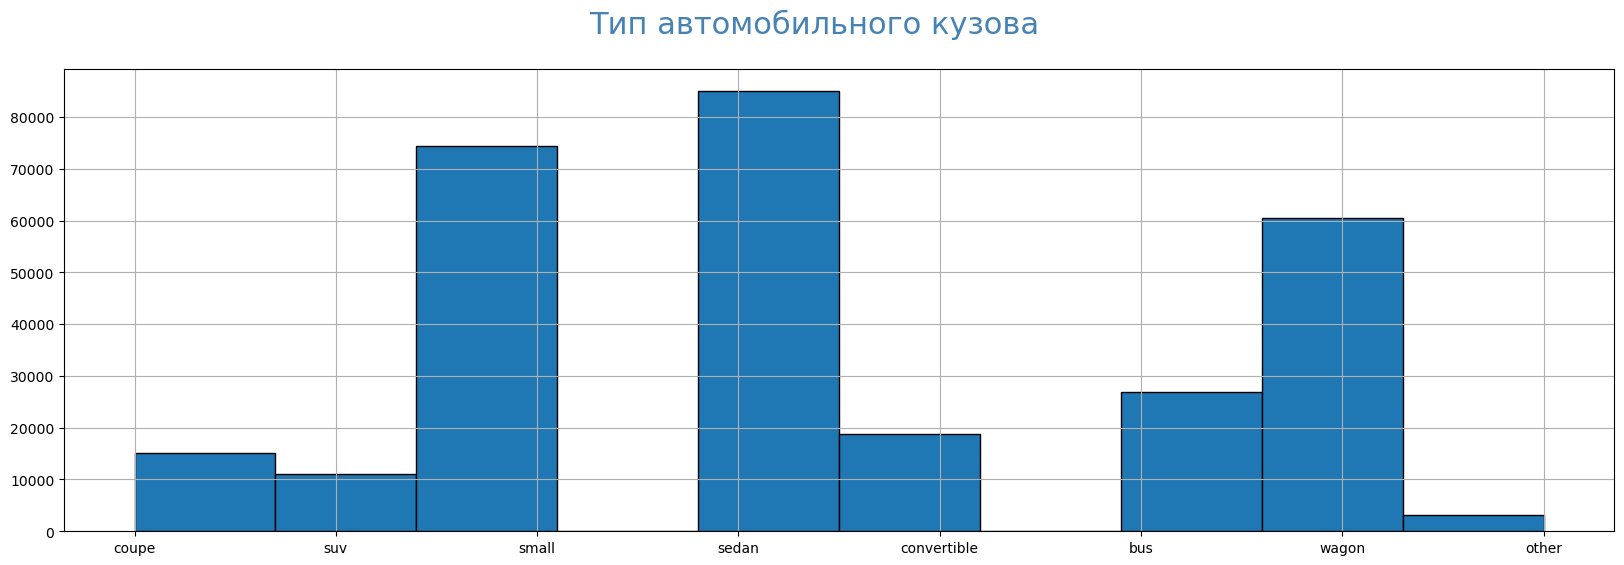

In [18]:
data['VehicleType'].hist(figsize=(20,6), edgecolor='black')
plt.suptitle('Тип автомобильного кузова', fontsize = 22, color = 'SteelBlue')
plt.show()

In [19]:
data[data['Model'] == 'golf']

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
9,999,small,1998,manual,101,golf,150000,NaN,volkswagen,NaN
32,245,sedan,1994,NaN,0,golf,150000,petrol,volkswagen,no
35,350,NaN,2016,manual,75,golf,150000,petrol,volkswagen,no
...,...,...,...,...,...,...,...,...,...,...
354315,1300,convertible,1998,manual,90,golf,150000,petrol,volkswagen,no
354320,1500,sedan,1999,manual,75,golf,150000,petrol,volkswagen,NaN
354348,5900,sedan,2006,manual,105,golf,150000,gasoline,volkswagen,no
354359,7900,sedan,2010,manual,140,golf,150000,gasoline,volkswagen,no


In [20]:
data[data['Model'] == 'golf']['VehicleType'].unique()

array([nan, 'small', 'sedan', 'bus', 'other', 'wagon', 'convertible',
       'coupe', 'suv'], dtype=object)

#### Gearbox

In [22]:
print(f"Посмотрим список коробок передач:\n{data['Gearbox'].unique()}")

Посмотрим список коробок передач:
['manual' 'auto' nan]


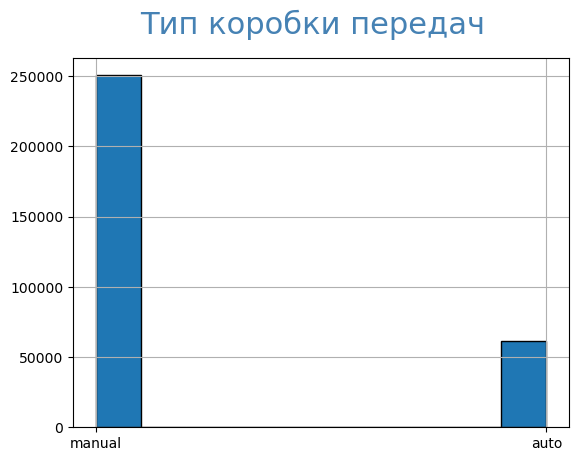

In [23]:
data['Gearbox'].hist(edgecolor='black')
plt.suptitle('Тип коробки передач', fontsize = 22, color = 'SteelBlue')
plt.show()

#### Model

In [25]:
print(f"Количество объявлений без указания модели: {data['Model'].isnull().sum()}")

Количество объявлений без указания модели: 18964


#### FuelType

In [27]:
print(f"Посмотрим список типов топлива:\n{data['FuelType'].unique()}")

Посмотрим список типов топлива:
['petrol' 'gasoline' nan 'lpg' 'other' 'hybrid' 'cng' 'electric']


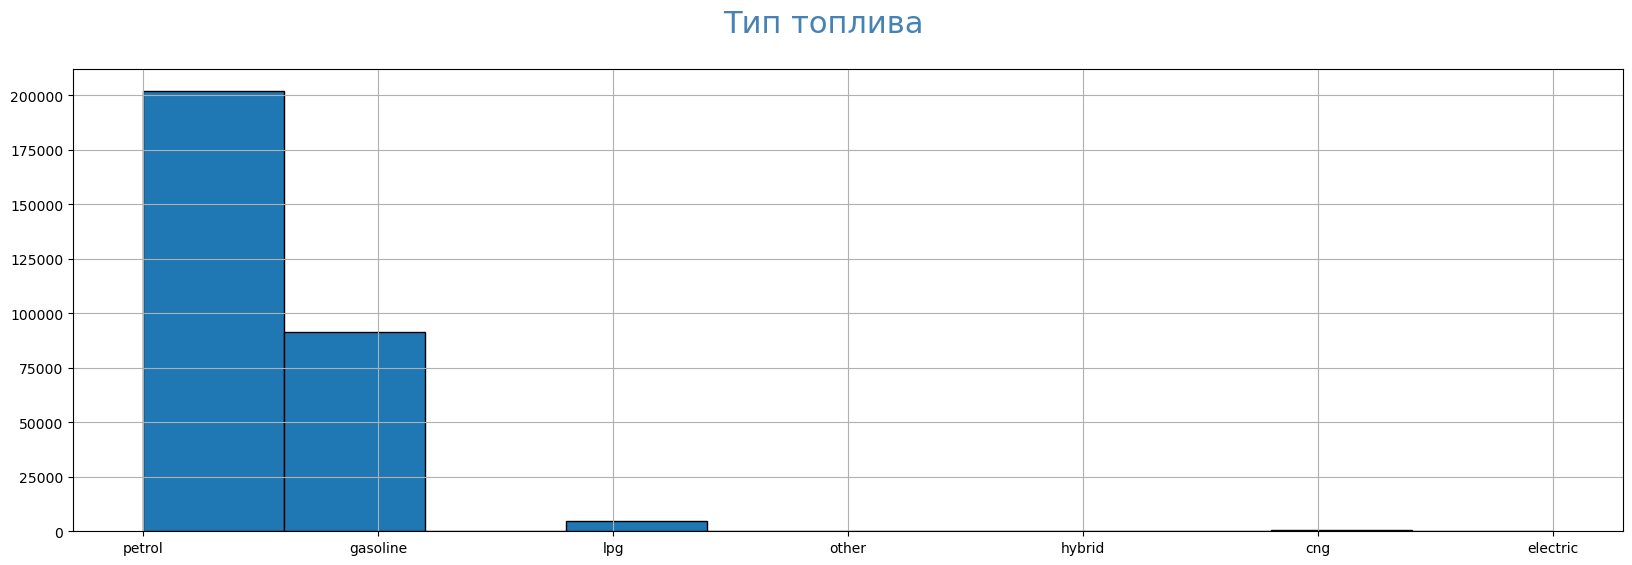

In [28]:
data['FuelType'].hist(figsize=(20,6), edgecolor='black')
plt.suptitle('Тип топлива', fontsize = 22, color = 'SteelBlue')
plt.show()

#### Repaired

In [30]:
print(f"Посмотрим список статуса \"ремонт\":\n{data['Repaired'].unique()}")

Посмотрим список статуса "ремонт":
[nan 'yes' 'no']


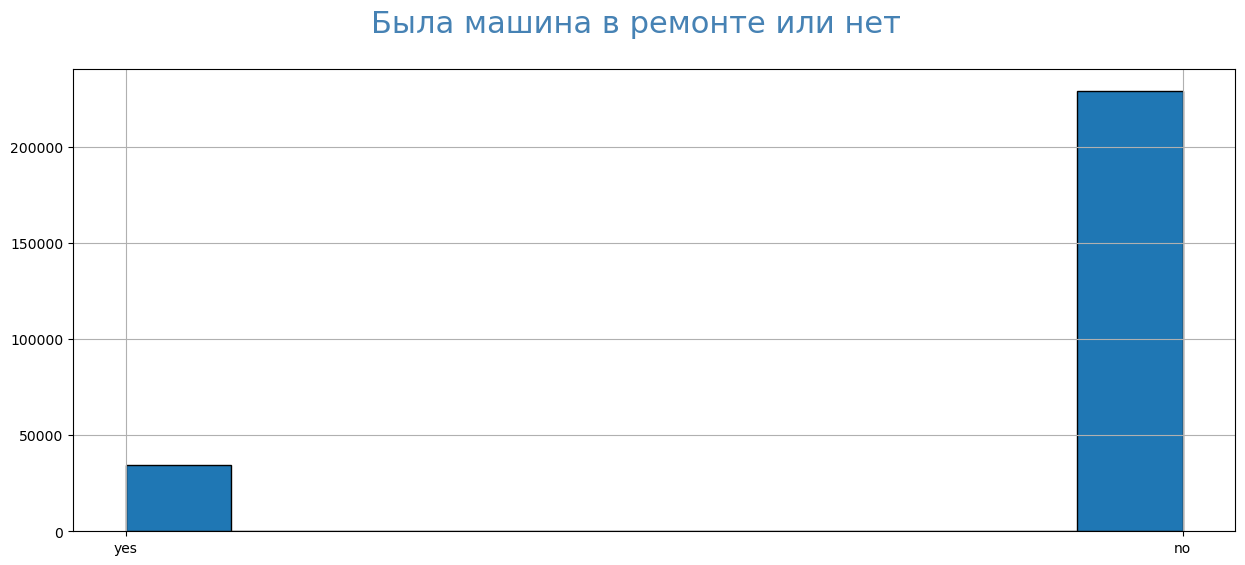

In [31]:
data['Repaired'].hist(figsize=(15,6), edgecolor='black')
plt.suptitle('Была машина в ремонте или нет', fontsize = 22, color = 'SteelBlue')
plt.show()

In [33]:
data[['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Repaired']] = \
    data[['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Repaired']].fillna('unknow')

### Изучение выборосов

Посмотрим на выбросы и обработаем их

In [36]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Price,330858.0,4381.797517,4506.414298,0.0,1000.0,2699.0,6300.0,20000.0
RegistrationYear,330858.0,2004.179548,89.511121,1000.0,1999.0,2003.0,2008.0,9999.0
Power,330858.0,109.799536,194.855656,0.0,68.0,103.0,140.0,20000.0
Kilometer,330858.0,128253.072315,37943.148027,5000.0,125000.0,150000.0,150000.0,150000.0


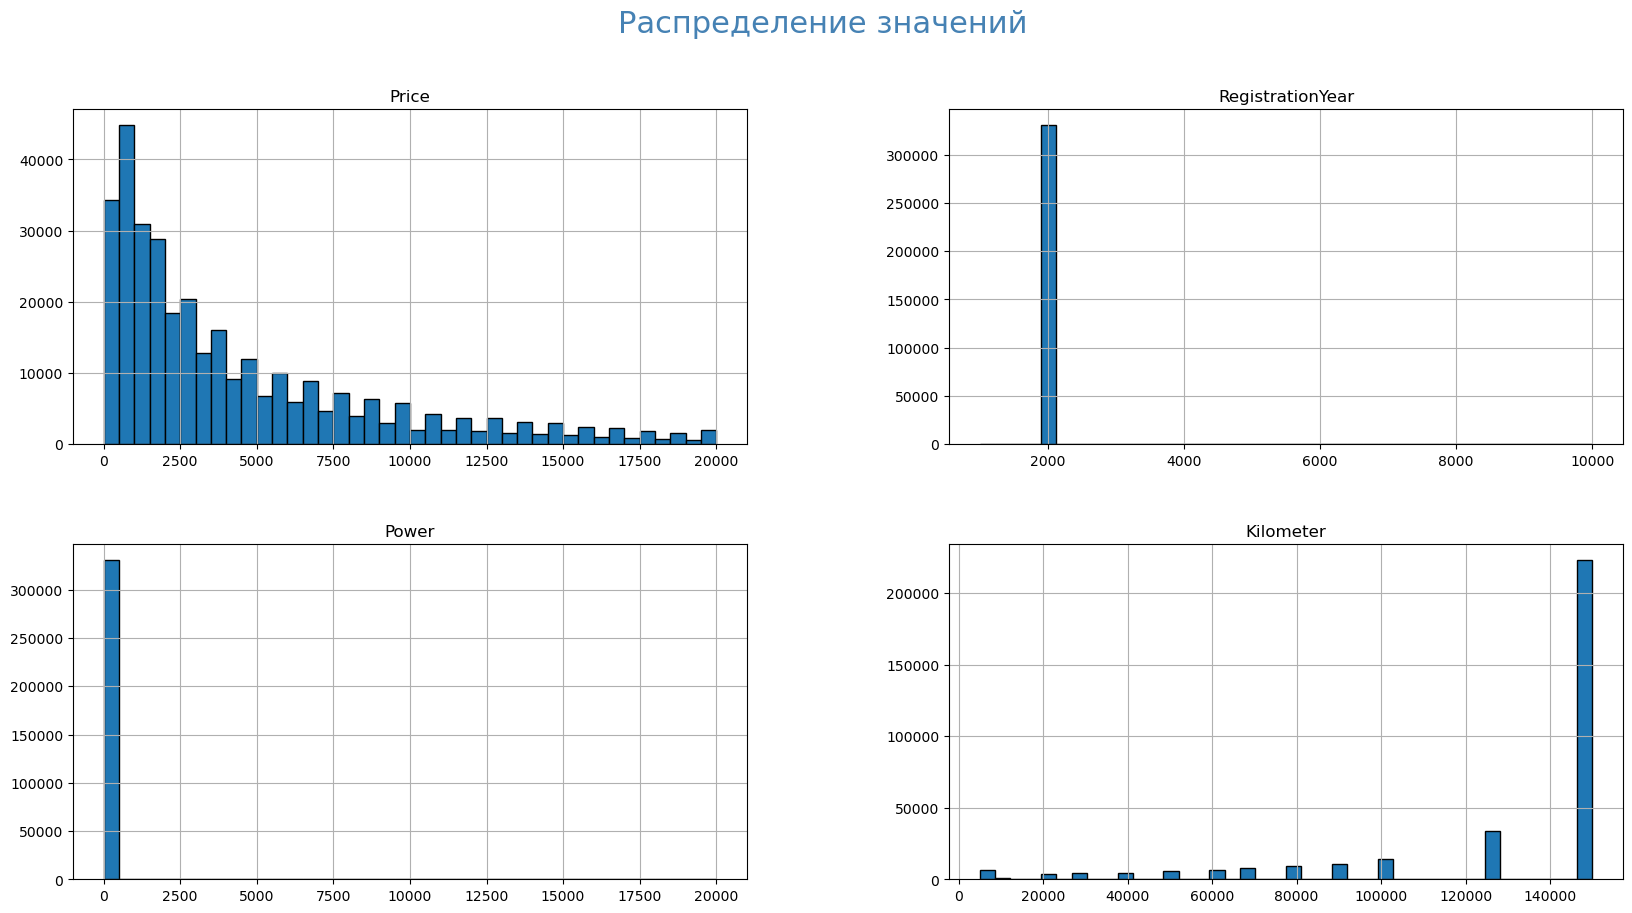

In [37]:
data.hist(bins=40, figsize=(20,10), edgecolor='black')
plt.suptitle('Распределение значений', fontsize = 22, color = 'SteelBlue')
plt.show()

Стоимость, год регистрации и мощность двигателя имеют выбросы. Месяц регистрации - 13 штук

#### Price

In [38]:
print(f"Количество анкет без стоимости: {data[data['Price'] == 0]['Price'].count()}")

Количество анкет без стоимости: 9923


Удалим такие анкеты - они помешают определить стоимости автомобиля

In [39]:
data = data[data['Price'] != 0]

#### RegistrationYear

Посмотрим на список годов

In [40]:
np.sort(data['RegistrationYear'].unique())

array([1000, 1001, 1039, 1111, 1234, 1255, 1300, 1400, 1500, 1600, 1602,
       1800, 1910, 1923, 1925, 1927, 1928, 1929, 1930, 1931, 1932, 1933,
       1934, 1935, 1936, 1937, 1938, 1940, 1941, 1942, 1943, 1944, 1945,
       1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956,
       1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967,
       1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978,
       1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989,
       1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000,
       2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
       2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2066, 2200, 2222,
       2290, 2500, 2800, 2900, 3000, 3200, 3700, 3800, 4000, 4100, 4500,
       4800, 5000, 5300, 5555, 5600, 5900, 5911, 6000, 6500, 7000, 7100,
       7800, 8000, 8200, 8500, 8888, 9000, 9450, 9999], dtype=int64)

In [41]:
data[data['RegistrationYear'] == 1910]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
15,450,small,1910,unknow,0,ka,5000,petrol,ford,unknow
6977,135,unknow,1910,unknow,0,unknow,5000,unknow,opel,unknow
10183,1250,unknow,1910,unknow,0,other,5000,unknow,audi,unknow
18023,1,unknow,1910,unknow,0,unknow,5000,unknow,volkswagen,unknow
23750,3900,wagon,1910,manual,90,passat,150000,petrol,volkswagen,unknow
24458,50,small,1910,manual,0,unknow,5000,unknow,volkswagen,yes
29516,80,small,1910,unknow,0,punto,150000,unknow,fiat,unknow
35943,200,other,1910,unknow,0,caddy,150000,gasoline,volkswagen,unknow
48958,600,small,1910,manual,0,agila,5000,unknow,opel,yes
57063,1000,unknow,1910,unknow,0,unknow,150000,unknow,sonstige_autos,unknow


In [43]:
print(f"Найдём кол-во анкет с аномальным годом регистрации (это года до 1910 и после 2016): {data[(data['RegistrationYear'] > 2016) | (data['RegistrationYear'] < 1910)].shape[0]}")

Найдём кол-во анкет с аномальным годом регистрации (это года до 1910 и после 2016): 13189


Удалим эти данные

In [45]:
data = data[(data['RegistrationYear'] >= 1910) & (data['RegistrationYear'] <= 2016)]

#### Power

In [46]:
print(f"Посмотрим на список мощностей двигателей:\n{np.sort(data['Power'].unique())}")

Посмотрим на список мощностей двигателей:
[    0     1     2     3     4     5     6     7     8     9    10    11
    12    13    14    15    16    17    18    19    20    21    22    23
    24    25    26    27    28    29    30    31    32    33    34    35
    36    37    38    39    40    41    42    43    44    45    46    47
    48    49    50    51    52    53    54    55    56    57    58    59
    60    61    62    63    64    65    66    67    68    69    70    71
    72    73    74    75    76    77    78    79    80    81    82    83
    84    85    86    87    88    89    90    91    92    93    94    95
    96    97    98    99   100   101   102   103   104   105   106   107
   108   109   110   111   112   113   114   115   116   117   118   119
   120   121   122   123   124   125   126   127   128   129   130   131
   132   133   134   135   136   137   138   139   140   141   142   143
   144   145   146   147   148   149   150   151   152   153   154   155
   156   

Очень подозрительно выглядит этот список. Что-то с ним не так. Посмотрев на линейку у "Гольфа" 1000+ л.с. выглядят немного фантастически

In [47]:
np.sort(data[data['Model'] == 'golf']['Power'].unique())

array([   0,    1,    4,    8,   10,   12,   40,   44,   45,   47,   50,
         51,   52,   53,   54,   55,   57,   58,   59,   60,   61,   63,
         64,   65,   66,   67,   68,   69,   70,   71,   72,   73,   74,
         75,   76,   77,   78,   79,   80,   81,   82,   83,   84,   85,
         86,   87,   88,   89,   90,   91,   92,   95,   96,   97,   98,
         99,  100,  101,  102,  103,  104,  105,  106,  107,  108,  109,
        110,  111,  112,  114,  115,  116,  117,  118,  120,  122,  123,
        124,  125,  129,  130,  131,  132,  133,  134,  135,  136,  137,
        139,  140,  141,  143,  144,  145,  147,  149,  150,  152,  156,
        158,  159,  160,  161,  163,  166,  169,  170,  171,  173,  174,
        175,  176,  177,  178,  179,  180,  181,  184,  185,  190,  192,
        193,  194,  196,  200,  204,  205,  206,  209,  210,  211,  213,
        215,  220,  222,  224,  226,  230,  235,  237,  239,  240,  241,
        242,  245,  246,  249,  250,  252,  254,  2

In [48]:
data[(data['Model'] == 'golf') & (data['Power'] > 650)]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
28942,300,wagon,1996,manual,1999,golf,10000,petrol,volkswagen,unknow
44520,2500,convertible,1998,manual,7512,golf,150000,unknow,volkswagen,unknow
45216,1690,sedan,1999,manual,7544,golf,125000,petrol,volkswagen,unknow
143909,2200,sedan,1998,auto,1781,golf,150000,petrol,volkswagen,yes
153907,4850,wagon,2007,auto,1054,golf,150000,gasoline,volkswagen,no
155393,600,small,1997,manual,1339,golf,30000,unknow,volkswagen,yes
164093,500,sedan,1992,manual,1781,golf,150000,petrol,volkswagen,unknow
195064,1800,sedan,1989,manual,1595,golf,40000,petrol,volkswagen,no
210610,4500,convertible,2002,manual,1011,golf,100000,unknow,volkswagen,no
249332,2600,sedan,2001,auto,1595,golf,5000,petrol,volkswagen,no


In [49]:
print(f"Найдём количество объявлений с мощностью более 1000 лс: {data[data['Power'] > 1000].shape[0]}")

Найдём количество объявлений с мощностью более 1000 лс: 258


Можно удалить такие объявления, тк их очень мало

In [50]:
data = data[data['Power'] <= 1000]

In [51]:
print(f"Найдём количество объявлений с мощностью менее 51 лс: {data[data['Power'] <= 50].shape[0]}")

Найдём количество объявлений с мощностью менее 51 лс: 40569


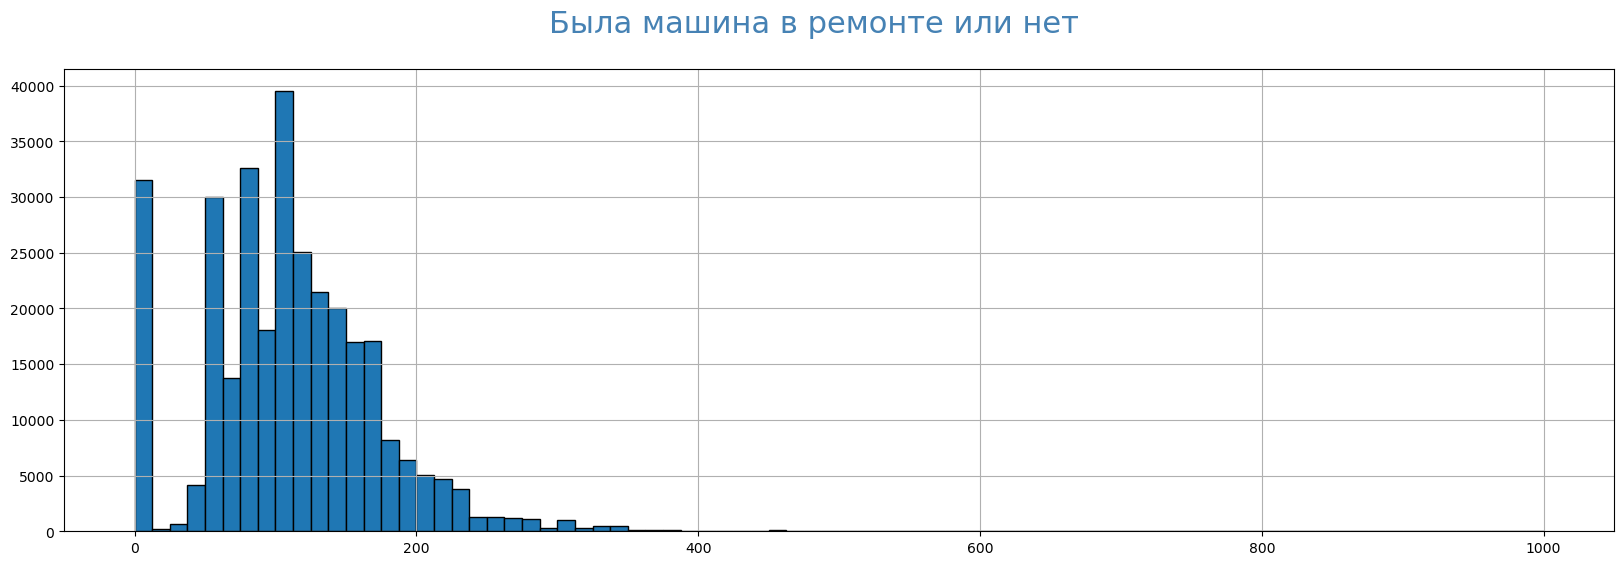

In [52]:
data['Power'].hist(bins=80, figsize=(20,6), edgecolor='black')
plt.suptitle('Была машина в ремонте или нет', fontsize = 22, color = 'SteelBlue')
plt.show()

Заменим такие значения медианными значениями пары бренд - модели. Если у такой пары значение ноль - вользмем медиану по бренду

In [57]:
data['Power'] = data['Power'].fillna(data.groupby(by=['Brand', 'Model'])['Power'].transform('median'))

In [58]:
data['Power'] = data.groupby('Model')['Power'].apply(lambda x: x.mask(x.lt(51)).fillna(x.median()))

In [60]:
data[data['Power'] < 50]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
534,4900,convertible,1973,manual,34.0,kaefer,90000,petrol,volkswagen,no
1844,1200,unknow,1970,manual,34.0,kaefer,150000,petrol,volkswagen,unknow
3209,500,unknow,1980,manual,34.0,kaefer,5000,petrol,volkswagen,unknow
3338,199,unknow,1995,manual,0.0,samara,100000,petrol,lada,unknow
5676,650,sedan,1985,manual,26.0,601,30000,petrol,trabant,yes
...,...,...,...,...,...,...,...,...,...,...
353040,10000,other,1988,manual,26.0,601,5000,petrol,trabant,unknow
353140,4900,small,1971,manual,34.0,kaefer,125000,petrol,volkswagen,no
353392,6999,small,1971,manual,34.0,kaefer,60000,petrol,volkswagen,no
353555,2199,unknow,2016,manual,0.0,samara,70000,unknow,lada,no


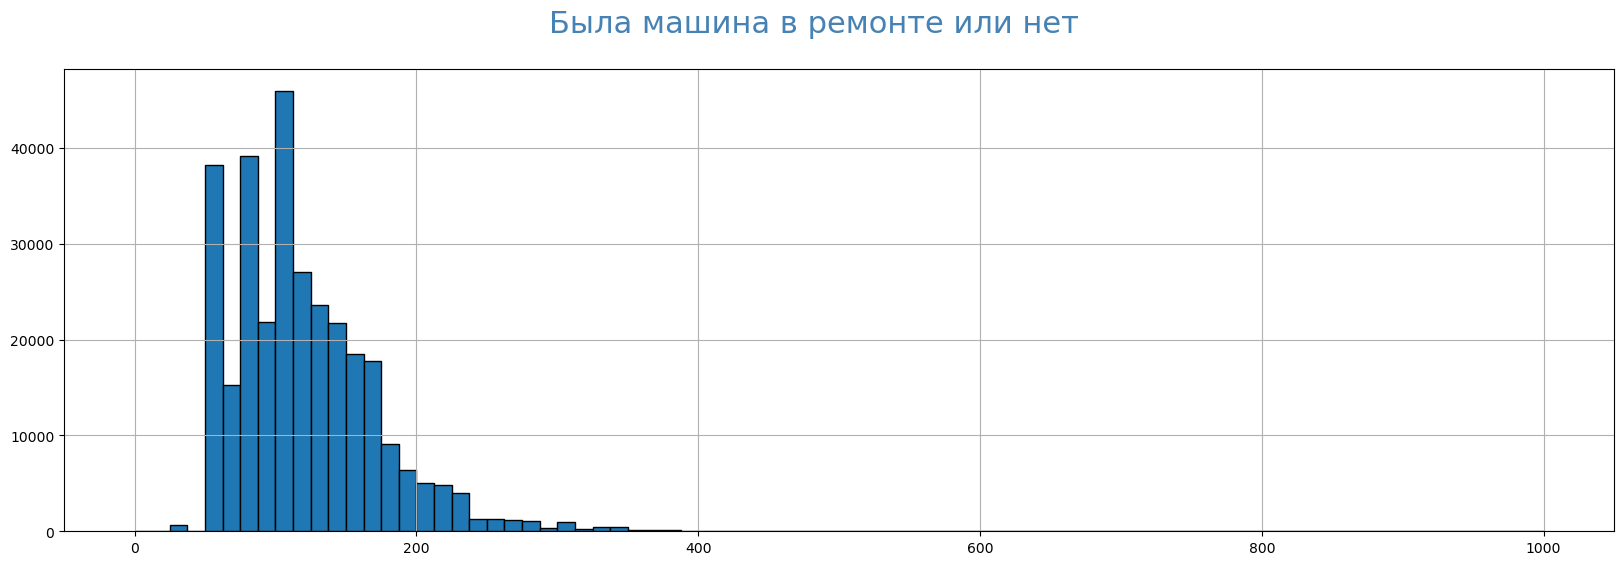

In [61]:
data['Power'].hist(bins=80, figsize=(20,6), edgecolor='black')
plt.suptitle('Была машина в ремонте или нет', fontsize = 22, color = 'SteelBlue')
plt.show()

Стало лучше

#### RegistrationMonth

Заменим ноль на рандомное значение от 1 до 12

In [64]:
data = data.reset_index(drop=True)

**С выбросами справились**

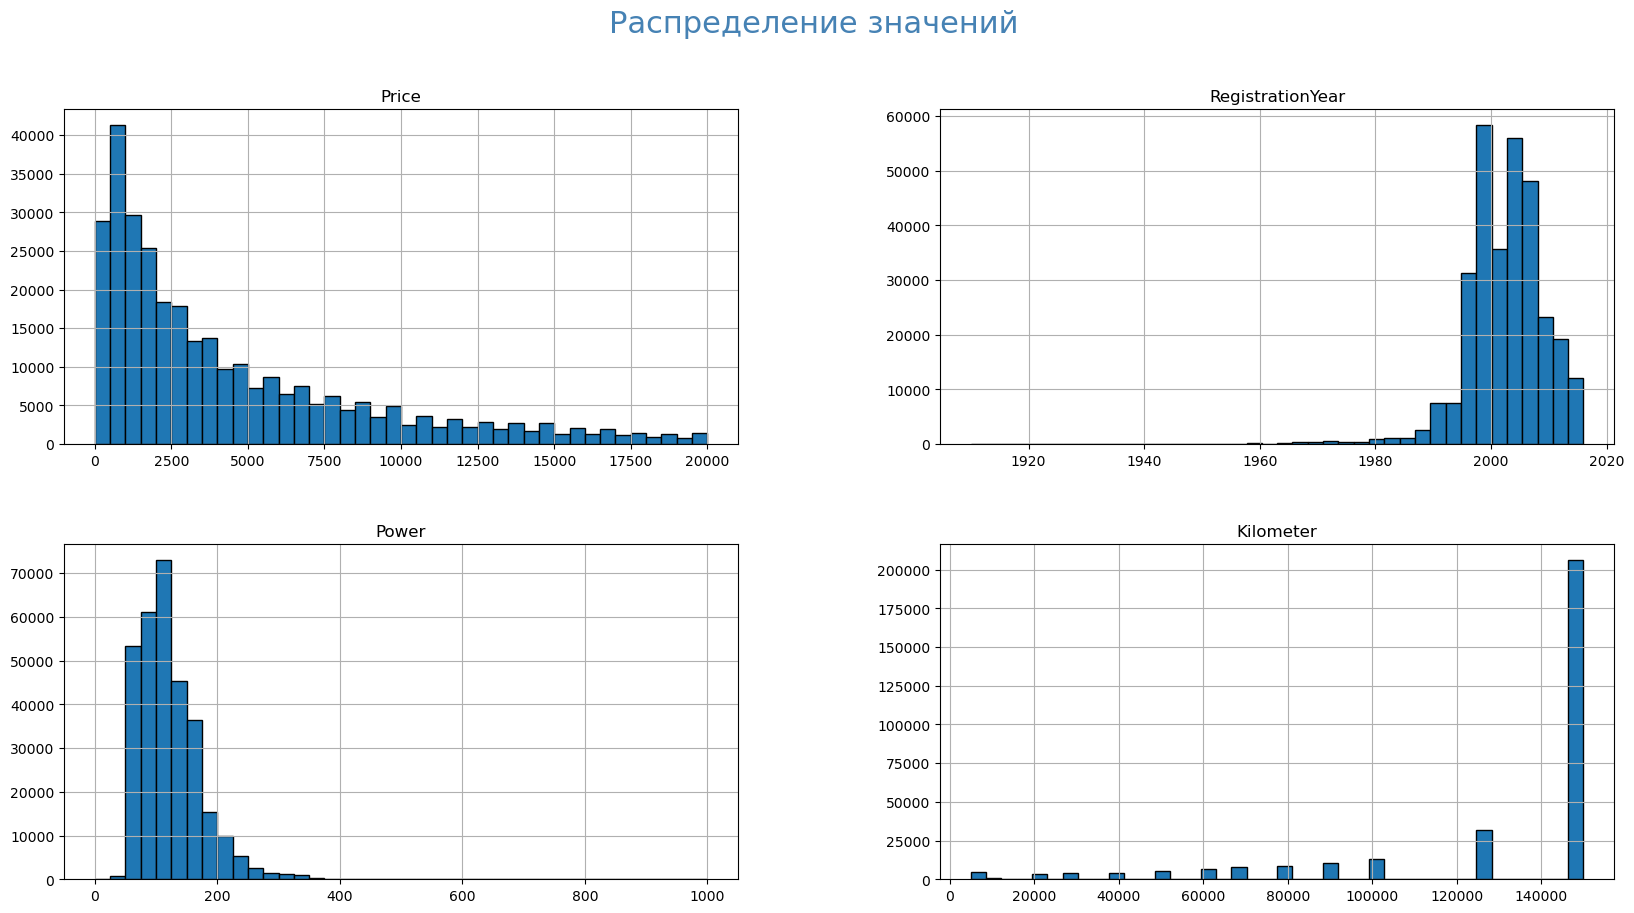

In [65]:
data.hist(bins=40, figsize=(20,10), edgecolor='black')
plt.suptitle('Распределение значений', fontsize = 22, color = 'SteelBlue')
plt.show()

### Визуализация данных

**Распределение по брендам**

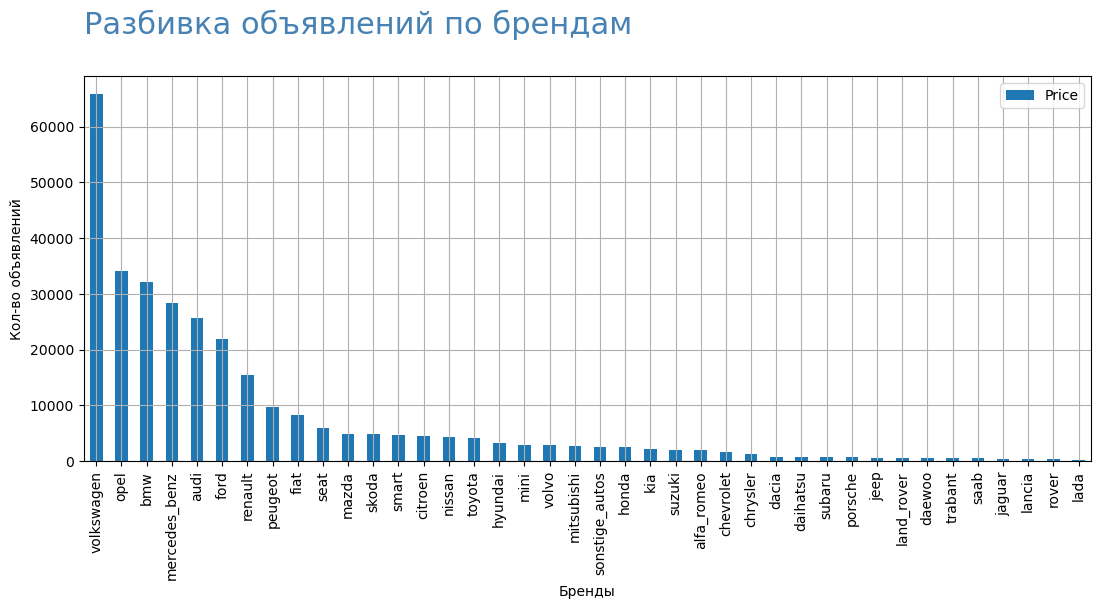

In [66]:
ax = (
data
.pivot_table(index='Brand', values='Price', aggfunc='count').sort_values(by='Price',ascending=False)
.plot( kind='bar',
    grid=True,
    figsize=(13,5))
)
ax.set_title('Разбивка объявлений по брендам' + "\n", loc="left", fontsize = 22, color = 'SteelBlue');
ax.set_xlabel("Бренды")
ax.set_ylabel("Кол-во объявлений");

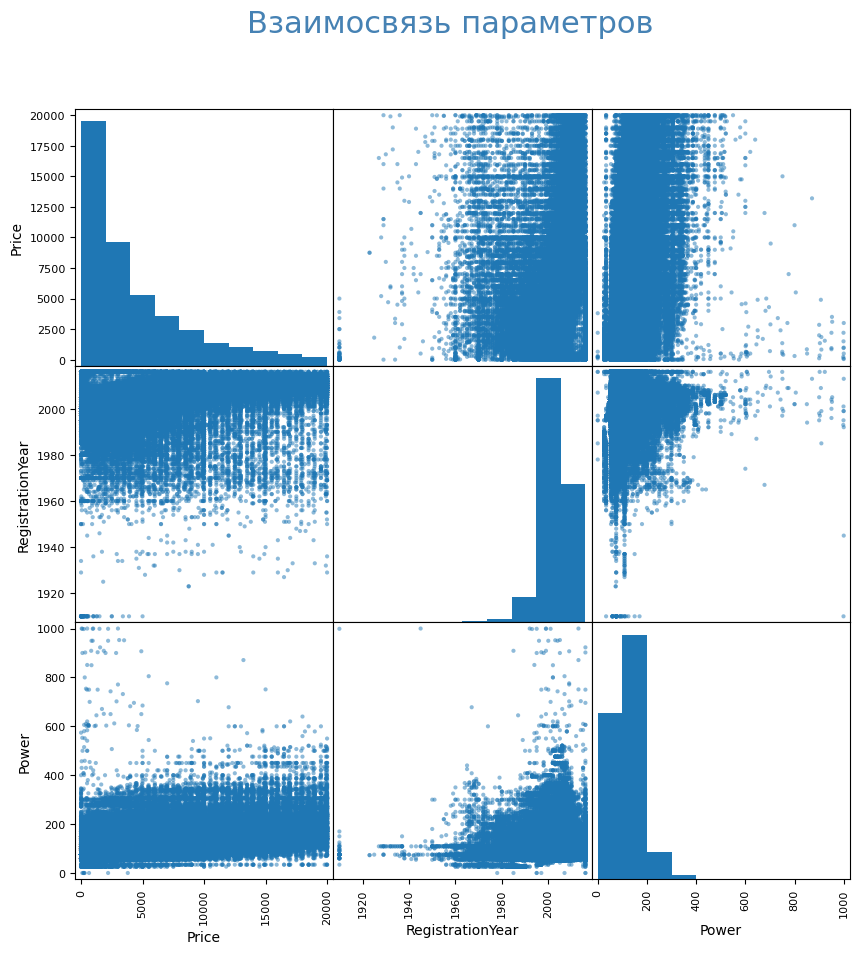

In [67]:
pd.plotting.scatter_matrix(data[['Price', 'RegistrationYear', 'Power']], figsize=(10, 10))
plt.suptitle('Взаимосвязь параметров', fontsize = 22, color = 'SteelBlue')
plt.show()

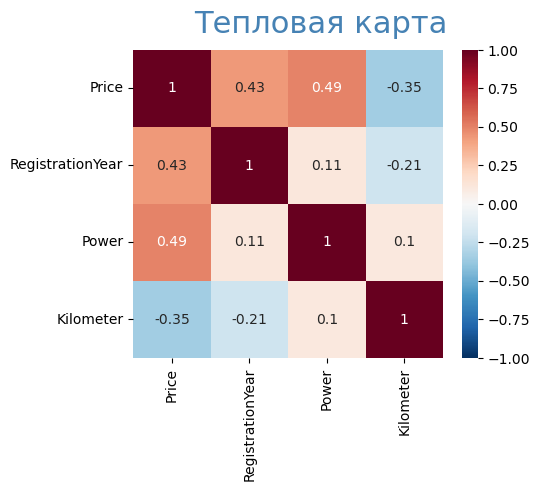

In [68]:
fig, ax = plt.subplots(figsize=(5,4)) 
sns.heatmap(data.corr(), cmap='RdBu_r', annot=True, vmin=-1, vmax=1, ax=ax)
plt.suptitle('Тепловая карта', fontsize = 22, color = 'SteelBlue')
plt.show()

Взаимосвязи параметров слабые  
Ни наличие ремонта, ни большой пробег не имеют большую корреляцию. На каждый параметр по отдельности  не стоит опираться при формировании стоимости

**ВЫВОД**:  

- Целевой признак - "Price"
- Тип данных каждого признака указанны корректно
- Часть признаков были удалены т.к. не имеют значения для цели задачи
- Обработали выбросы - совсем большие - удалили (год регистрации, например), часть данные переопределили медианнным значением

## Обучение моделей

### Подготовка данных

Наш целевой показатель "Price". Данные делим на обучающую, валидационную и тестовую выборки. После этого переведем все категориальные признаки в числовые

In [69]:
X_train, y_train, X_valid, y_valid, X_test, y_test = \
train_valid_test_split(data, 
                       'Price', 
                       train_size=0.7, 
                       valid_size=0.15, 
                       test_size=0.15, 
                       random_state=12345)

In [70]:
print(f"Посмотрим на размеры наших выбороу\n{X_train.shape} {X_valid.shape} {X_test.shape}\n{y_train.shape} {y_valid.shape} {y_test.shape}")

Посмотрим на размеры наших выбороу
(215241, 9) (46123, 9) (46124, 9)
(215241,) (46123,) (46124,)


In [71]:
data.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,unknow,1993,manual,98.0,golf,150000,petrol,volkswagen,unknow
1,18300,coupe,2011,manual,190.0,unknow,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163.0,grand,125000,gasoline,jeep,unknow
3,1500,small,2001,manual,75.0,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69.0,fabia,90000,gasoline,skoda,no


In [72]:
#категориальные признаки
obj_features = X_train.select_dtypes(include='object').columns.to_list()
print(obj_features)

['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']


In [73]:
#численные признаки
num_features = X_train.select_dtypes(exclude='object').columns.to_list()
num_features

['RegistrationYear', 'Power', 'Kilometer']

In [74]:
# Создание экземпляра MEstimateEncoder
encoder = MEstimateEncoder(cols=obj_features, m=10)

# Применение кодирования категориальных переменных на тренировочном наборе
encoded_X_train = encoder.fit_transform(X_train, y_train)

# Применение полученных средних значений для замены категориальных значений в тестовом и валидационном наборах
encoded_X_valid = encoder.transform(X_valid)
encoded_X_test = encoder.transform(X_test)

# Обучение модели машинного обучения на новых закодированных признаках
encoder.fit(encoded_X_train, y_train)

MEstimateEncoder(cols=['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand',
                       'Repaired'],
                 m=10)

In [75]:
# Определение метрики RMSE как scoring
scoring = make_scorer(mean_squared_error, squared=False)

### Посмотрим на равнометрость распределения данных между выборками

In [76]:
encoded_X_train.head(5)

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
194420,2728.450186,1997,4099.566191,101.0,4568.424882,150000,3875.178674,6434.289979,5386.762153
65490,5500.937586,2005,4099.566191,113.0,4568.424882,150000,6645.335033,5206.056024,5386.762153
18423,4798.328108,1977,4099.566191,132.0,4568.424882,150000,3875.178674,3217.218847,5386.762153
82155,6210.884321,2011,4099.566191,213.0,4568.424882,90000,3875.178674,5206.056024,5386.762153
142062,6210.884321,1996,4099.566191,102.0,5151.545439,150000,3875.178674,6364.044738,5386.762153


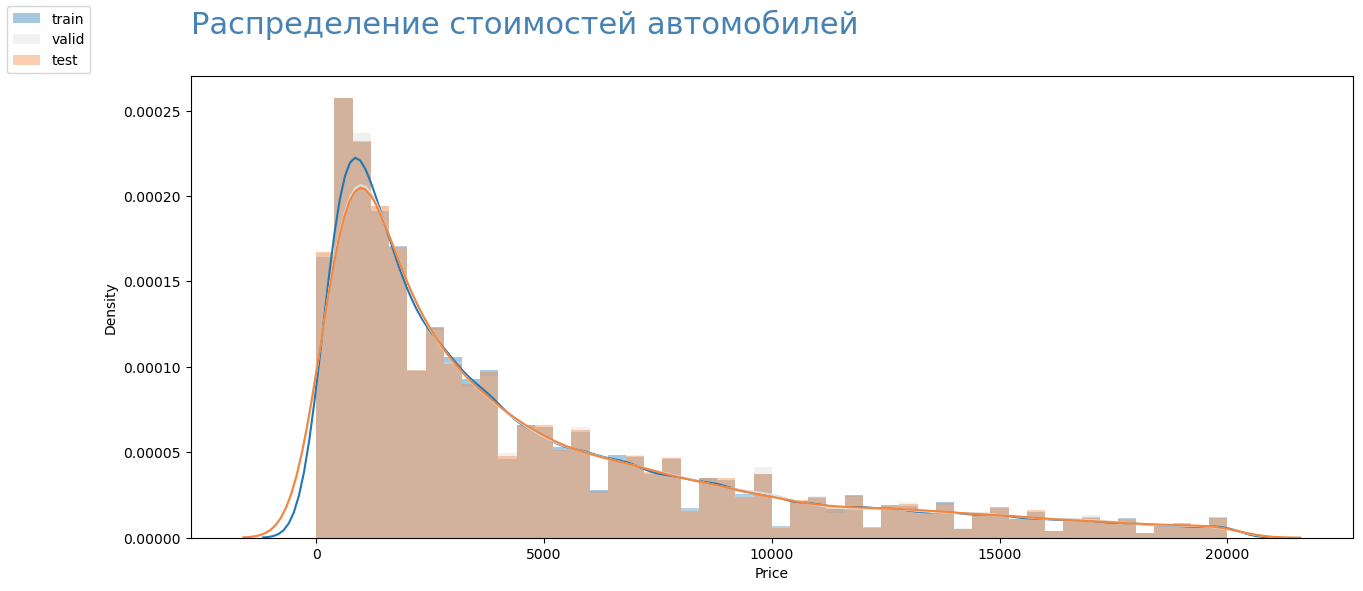

In [77]:
fig = plt.figure(figsize=(15,6))
sns.distplot(y_train, label='train')
sns.distplot(y_valid, label='valid', color='#dddddd')
sns.distplot(y_test, label='test', color='#f5853b')
fig.legend(loc='upper left')
plt.title('Распределение стоимостей автомобилей' + "\n", loc="left", fontsize = 22, color = 'SteelBlue');

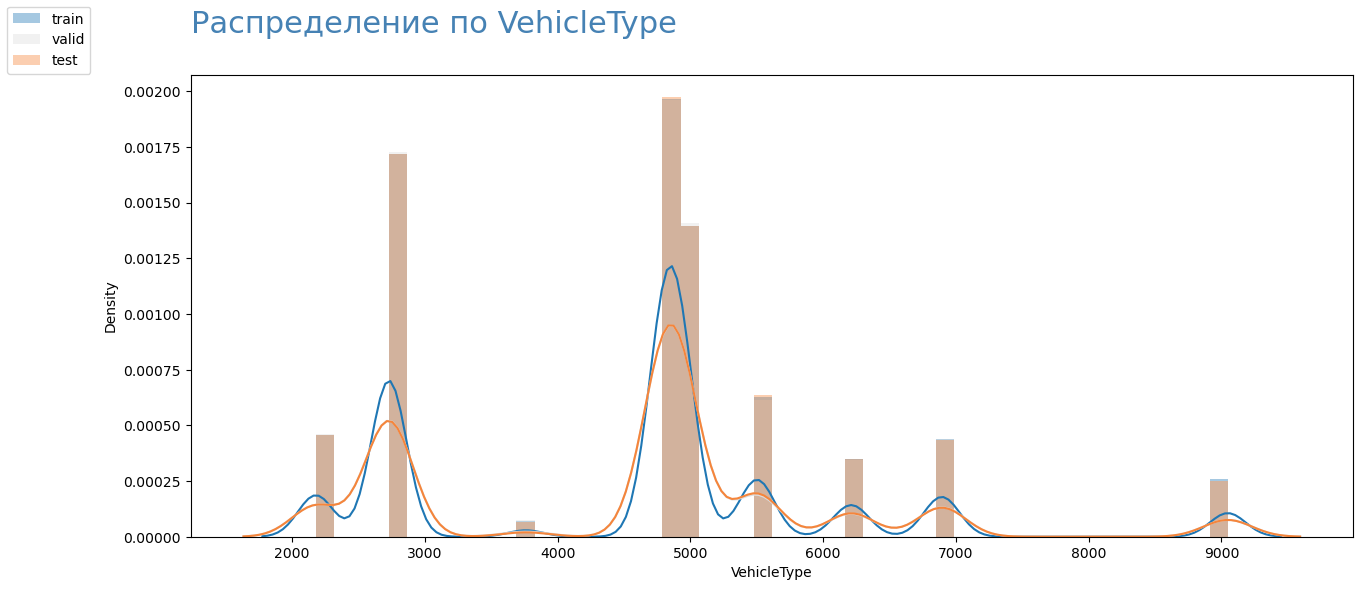

In [78]:
fig = plt.figure(figsize=(15,6))
sns.distplot(encoded_X_train['VehicleType'], label='train')
sns.distplot(encoded_X_valid['VehicleType'], label='valid', color='#dddddd')
sns.distplot(encoded_X_test['VehicleType'], label='test', color='#f5853b')
fig.legend(loc='upper left')
plt.title('Распределение по VehicleType' + "\n", loc="left", fontsize = 22, color = 'SteelBlue');

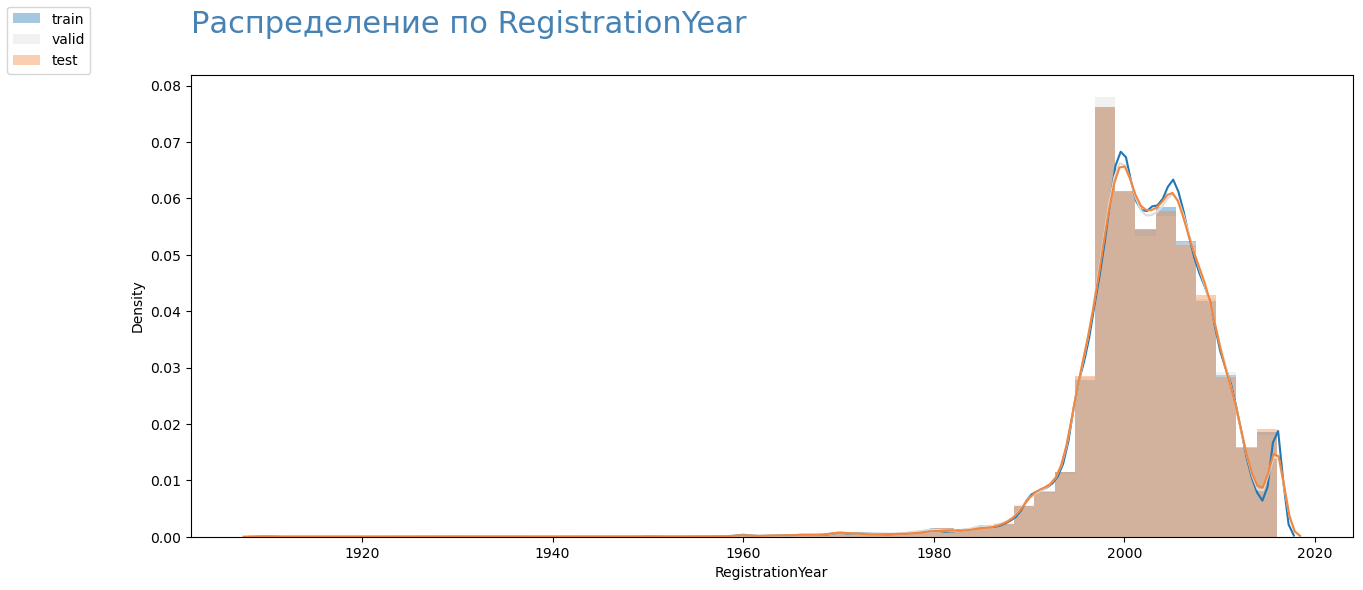

In [79]:
fig = plt.figure(figsize=(15,6))
sns.distplot(encoded_X_train['RegistrationYear'], label='train')
sns.distplot(encoded_X_valid['RegistrationYear'], label='valid', color='#dddddd')
sns.distplot(encoded_X_test['RegistrationYear'], label='test', color='#f5853b')
fig.legend(loc='upper left')
plt.title('Распределение по RegistrationYear' + "\n", loc="left", fontsize = 22, color = 'SteelBlue');

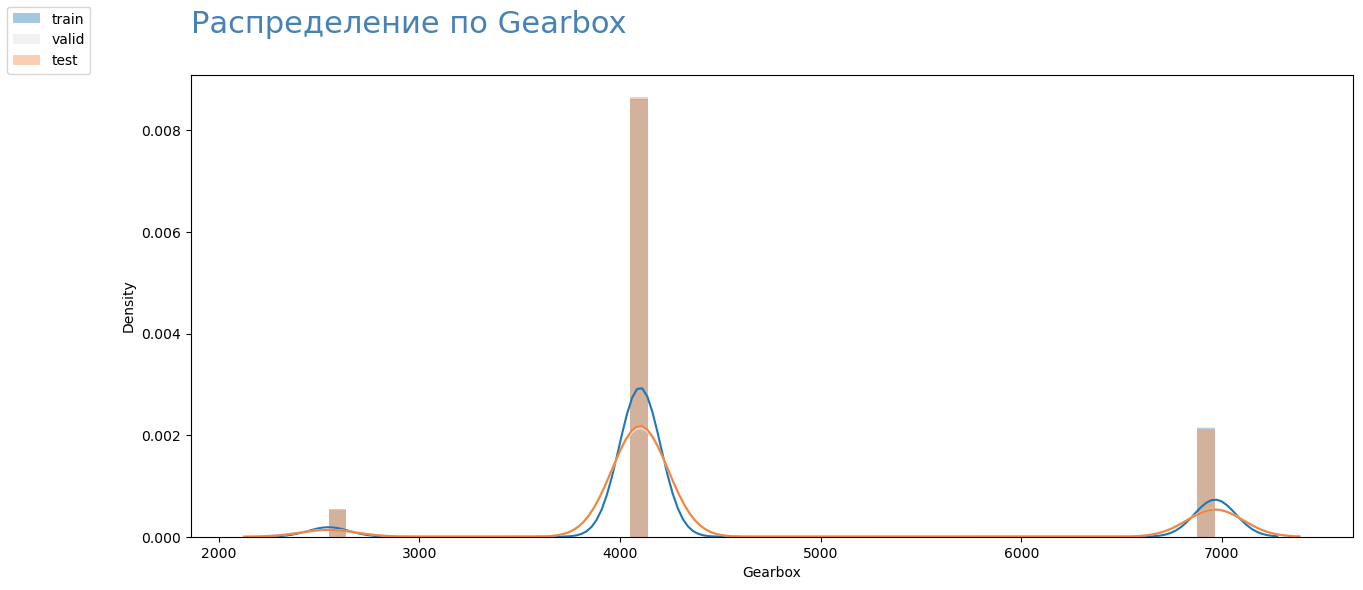

In [80]:
fig = plt.figure(figsize=(15,6))
sns.distplot(encoded_X_train['Gearbox'], label='train')
sns.distplot(encoded_X_valid['Gearbox'], label='valid', color='#dddddd')
sns.distplot(encoded_X_test['Gearbox'], label='test', color='#f5853b')
fig.legend(loc='upper left')
plt.title('Распределение по Gearbox' + "\n", loc="left", fontsize = 22, color = 'SteelBlue');

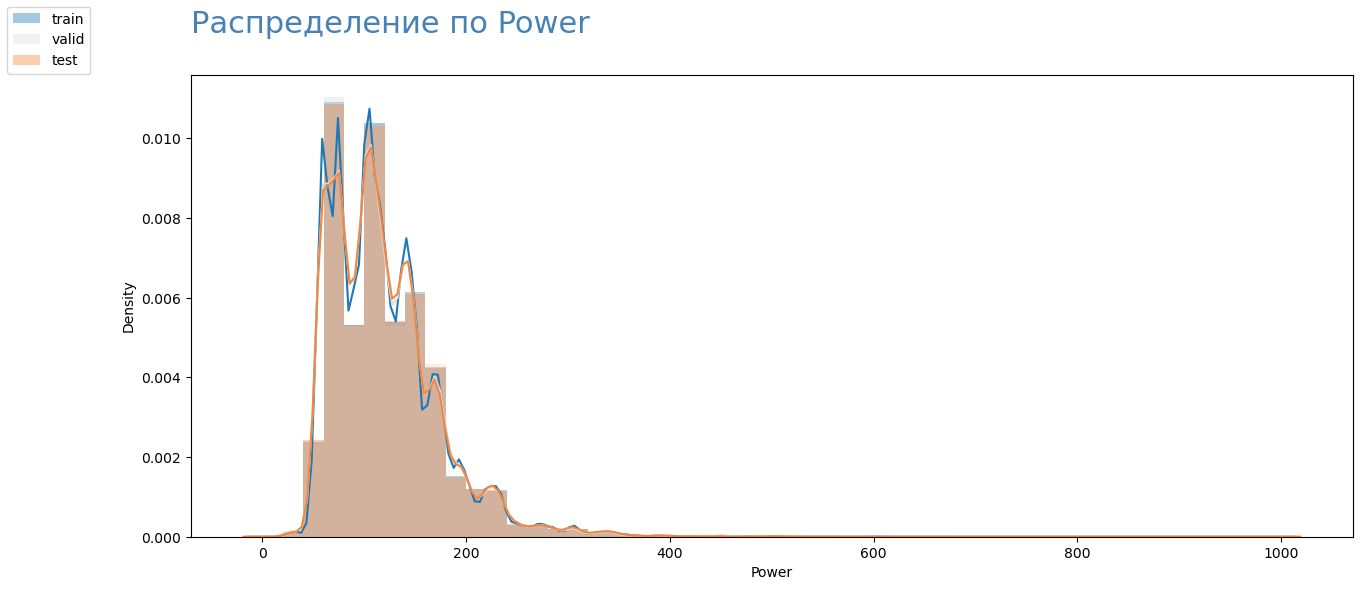

In [81]:
fig = plt.figure(figsize=(15,6))
sns.distplot(encoded_X_train['Power'], label='train')
sns.distplot(encoded_X_valid['Power'], label='valid', color='#dddddd')
sns.distplot(encoded_X_test['Power'], label='test', color='#f5853b')
fig.legend(loc='upper left')
plt.title('Распределение по Power' + "\n", loc="left", fontsize = 22, color = 'SteelBlue');

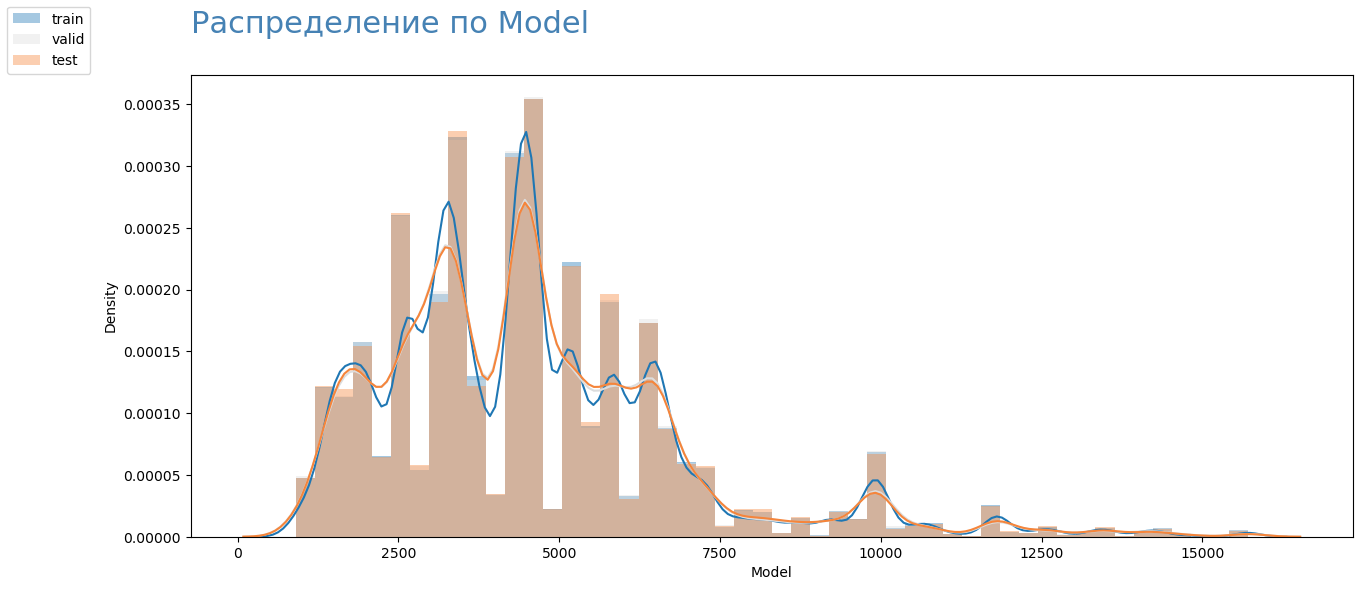

In [82]:
fig = plt.figure(figsize=(15,6))
sns.distplot(encoded_X_train['Model'], label='train')
sns.distplot(encoded_X_valid['Model'], label='valid', color='#dddddd')
sns.distplot(encoded_X_test['Model'], label='test', color='#f5853b')
fig.legend(loc='upper left')
plt.title('Распределение по Model' + "\n", loc="left", fontsize = 22, color = 'SteelBlue');

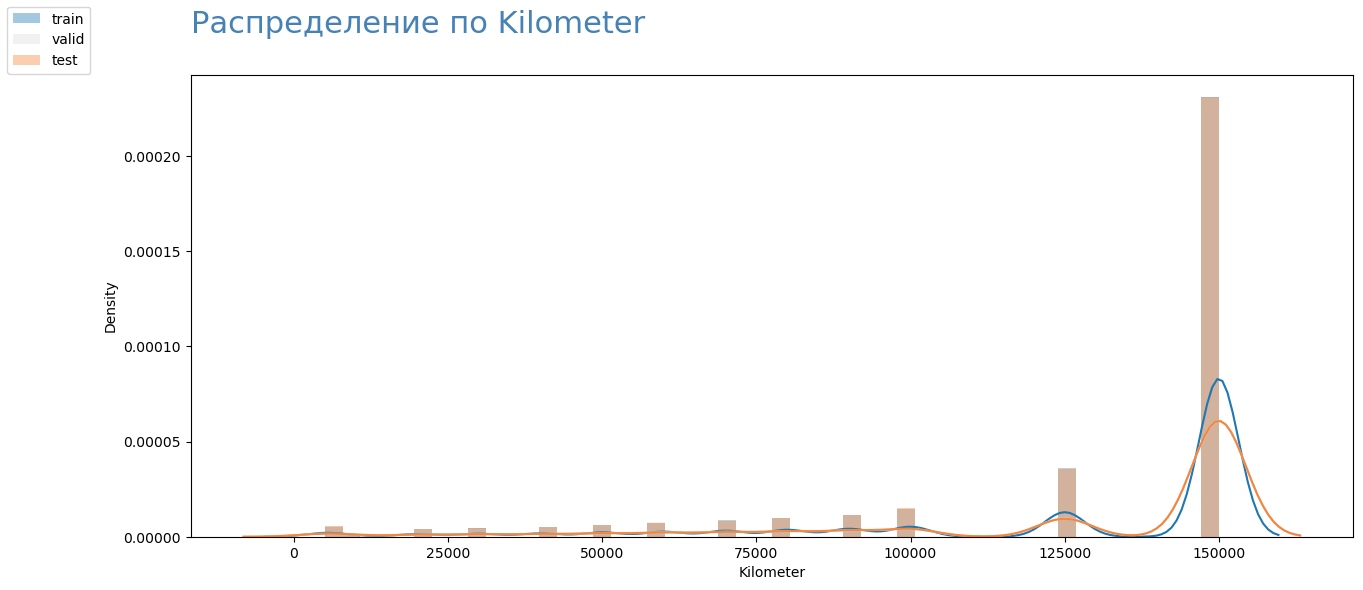

In [83]:
fig = plt.figure(figsize=(15,6))
sns.distplot(encoded_X_train['Kilometer'], label='train')
sns.distplot(encoded_X_valid['Kilometer'], label='valid', color='#dddddd')
sns.distplot(encoded_X_test['Kilometer'], label='test', color='#f5853b')
fig.legend(loc='upper left')
plt.title('Распределение по Kilometer' + "\n", loc="left", fontsize = 22, color = 'SteelBlue');

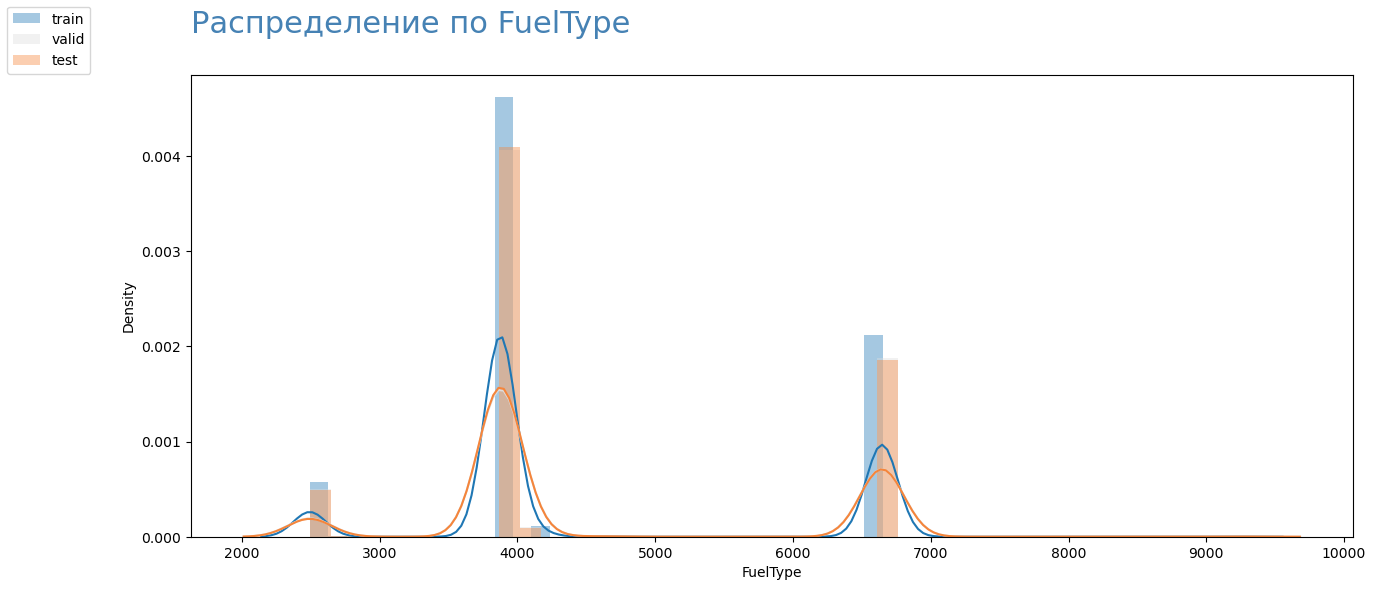

In [84]:
fig = plt.figure(figsize=(15,6))
sns.distplot(encoded_X_train['FuelType'], label='train')
sns.distplot(encoded_X_valid['FuelType'], label='valid', color='#dddddd')
sns.distplot(encoded_X_test['FuelType'], label='test', color='#f5853b')
fig.legend(loc='upper left')
plt.title('Распределение по FuelType' + "\n", loc="left", fontsize = 22, color = 'SteelBlue');

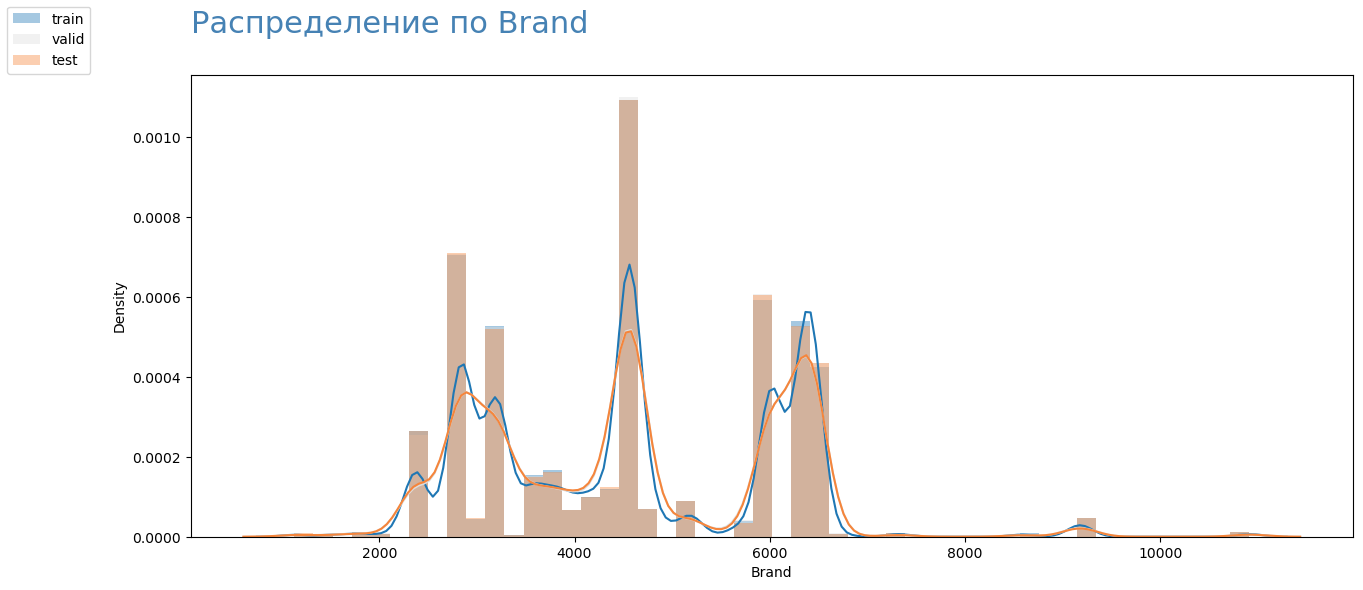

In [85]:
fig = plt.figure(figsize=(15,6))
sns.distplot(encoded_X_train['Brand'], label='train')
sns.distplot(encoded_X_valid['Brand'], label='valid', color='#dddddd')
sns.distplot(encoded_X_test['Brand'], label='test', color='#f5853b')
fig.legend(loc='upper left')
plt.title('Распределение по Brand' + "\n", loc="left", fontsize = 22, color = 'SteelBlue');

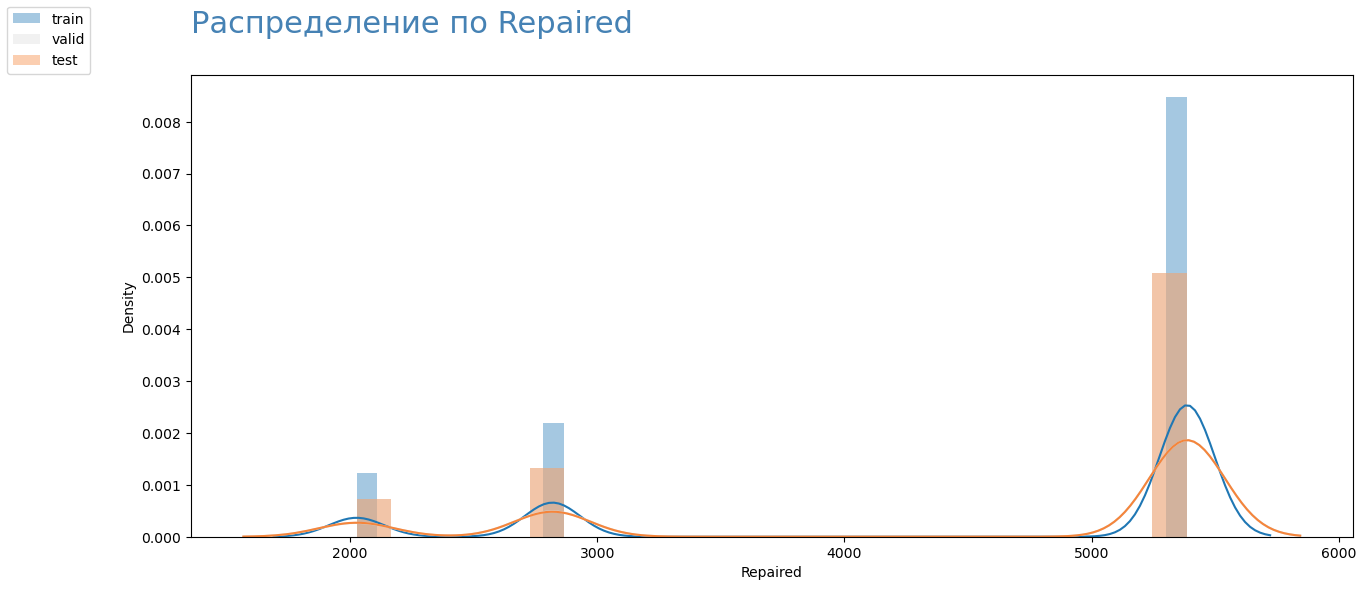

In [86]:
fig = plt.figure(figsize=(15,6))
sns.distplot(encoded_X_train['Repaired'], label='train')
sns.distplot(encoded_X_valid['Repaired'], label='valid', color='#dddddd')
sns.distplot(encoded_X_test['Repaired'], label='test', color='#f5853b')
fig.legend(loc='upper left')
plt.title('Распределение по Repaired' + "\n", loc="left", fontsize = 22, color = 'SteelBlue');

Применив MEstimateEncoder из бибтилотеки Category Encoders мы преобразовали категориальные признаки и смогли избавиться от проклятия размерности

### LightGBM

In [94]:
# Список гиперпараметров
params = {
    'num_leaves': [31, 50, 100],
    'max_depth': [None, 5, 10],
    'learning_rate': [0.01, 0.1, 1],
    'n_estimators': [100, 200, 300],
    'random_state': [12345]
}

In [96]:
start_lgb = datetime.now()

model_lgb = LGBMRegressor(random_state=12345)
search = RandomizedSearchCV(estimator=model_lgb, param_distributions=params, n_iter=10, cv=5, verbose=2, scoring=scoring, random_state=12345)
search.fit(encoded_X_train, y_train)

time_lgb = datetime.now() - start_lgb
print(time_lgb)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003244 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 655
[LightGBM] [Info] Number of data points in the train set: 172192, number of used features: 9
[LightGBM] [Info] Start training from score 4578.526726
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[CV] END learning_rate=0.1, max_depth=10, n_estimators=100, num_leaves=31, random_state=12345; total time=   0.2s
[LightGBM] [Warning] Acc

In [97]:
best_params_lgb = search.best_params_
best_model_lgb = search.best_estimator_
best_rmse_lgb = round(search.best_score_, 2)
print('Подобранные параметры:')
pprint(best_params_lgb)
print('RMSE по подобранным параметрам:', best_rmse_lgb)
print('Время поиска параметров:', time_lgb)

Подобранные параметры:
{'learning_rate': 0.01,
 'max_depth': None,
 'n_estimators': 100,
 'num_leaves': 100,
 'random_state': 12345}
RMSE по подобранным параметрам: 2482.23
Время поиска параметров: 0:00:20.692448


In [98]:
# Создаём модель по полученным параметрам
best_model_lgb = LGBMRegressor(**best_params_lgb)
best_model_lgb.fit(encoded_X_train, y_train)
y_pred = best_model_lgb.predict(encoded_X_valid)
rmse_lgb = round(mean_squared_error(y_valid, y_pred)**(0.5), 2)
print(f"RMSE: {rmse_lgb}\n")

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002802 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 657
[LightGBM] [Info] Number of data points in the train set: 215241, number of used features: 9
[LightGBM] [Info] Start training from score 4567.554137
RMSE: 2506.0



### XGBoost

In [103]:
# Список гиперпараметров
params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.5, 1],
    'gamma': [0, 0.1, 0.2],
    'colsample_bytree': [0.5, 0.7, 1],
    'random_state': [12345]
}

In [105]:
start_xgb = datetime.now()

model_xgb = XGBRegressor(random_state=12345)
search = RandomizedSearchCV(estimator=model_xgb, param_distributions=params, n_iter=10, cv=5, verbose=2, scoring=scoring, random_state=12345)
search.fit(encoded_X_train, y_train)

time_xgb = datetime.now() - start_xgb
print(time_xgb)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END colsample_bytree=1, gamma=0.1, learning_rate=0.5, max_depth=7, n_estimators=100, random_state=12345; total time=   1.2s
[CV] END colsample_bytree=1, gamma=0.1, learning_rate=0.5, max_depth=7, n_estimators=100, random_state=12345; total time=   1.2s
[CV] END colsample_bytree=1, gamma=0.1, learning_rate=0.5, max_depth=7, n_estimators=100, random_state=12345; total time=   1.2s
[CV] END colsample_bytree=1, gamma=0.1, learning_rate=0.5, max_depth=7, n_estimators=100, random_state=12345; total time=   1.2s
[CV] END colsample_bytree=1, gamma=0.1, learning_rate=0.5, max_depth=7, n_estimators=100, random_state=12345; total time=   1.2s
[CV] END colsample_bytree=1, gamma=0.2, learning_rate=1, max_depth=3, n_estimators=300, random_state=12345; total time=   1.4s
[CV] END colsample_bytree=1, gamma=0.2, learning_rate=1, max_depth=3, n_estimators=300, random_state=12345; total time=   1.4s
[CV] END colsample_bytree=1, gamma=0.2, 

In [106]:
best_params_xgb = search.best_params_
best_model_xgb = search.best_estimator_
best_rmse_xgb = round(search.best_score_, 2)
print('Подобранные параметры:')
pprint(best_params_xgb)
print('RMSE по подобранным параметрам:', best_rmse_xgb)
print('Время поиска параметров:', time_xgb)

Подобранные параметры:
{'colsample_bytree': 0.5,
 'gamma': 0,
 'learning_rate': 1,
 'max_depth': 3,
 'n_estimators': 100,
 'random_state': 12345}
RMSE по подобранным параметрам: 1830.01
Время поиска параметров: 0:01:40.925196


In [108]:
# Создаём модель по полученным параметрам
best_model_xgb = XGBRegressor(**best_params_xgb)
best_model_xgb.fit(encoded_X_train, y_train)
y_pred = best_model_xgb.predict(encoded_X_valid)
rmse_xgb = round(mean_squared_error(y_valid, y_pred)**(0.5), 2)
print(f"RMSE: {rmse_xgb}\n")

RMSE: 1840.56



### LinearRegression

In [116]:
start_lr = datetime.now()

params = {
    'regressor__fit_intercept': [True, False]
}
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])
search = RandomizedSearchCV(estimator=pipeline, param_distributions=params, n_iter=10, cv=5, verbose=2, scoring=scoring, random_state=12345)
search.fit(encoded_X_train, y_train)

time_lr = datetime.now() - start_lr
print(time_lr)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] END ......................regressor__fit_intercept=True; total time=   0.0s
[CV] END ......................regressor__fit_intercept=True; total time=   0.0s
[CV] END ......................regressor__fit_intercept=True; total time=   0.0s
[CV] END ......................regressor__fit_intercept=True; total time=   0.0s
[CV] END ......................regressor__fit_intercept=True; total time=   0.0s
[CV] END .....................regressor__fit_intercept=False; total time=   0.0s
[CV] END .....................regressor__fit_intercept=False; total time=   0.0s
[CV] END .....................regressor__fit_intercept=False; total time=   0.0s
[CV] END .....................regressor__fit_intercept=False; total time=   0.0s
[CV] END .....................regressor__fit_intercept=False; total time=   0.0s
0:00:00.490153


In [117]:
best_params_lr = search.best_params_
best_model_lr = search.best_estimator_
best_rmse_lr = round(search.best_score_, 2)
print('Подобранные параметры:')
pprint(best_params_lr)
print('RMSE по подобранным параметрам:', best_rmse_lr)
print('Время поиска параметров:', time_lr)

Подобранные параметры:
{'regressor__fit_intercept': False}
RMSE по подобранным параметрам: 5380.52
Время поиска параметров: 0:00:00.490153


In [118]:
# Создаём модель по полученным параметрам
best_model_lr.fit(encoded_X_train, y_train)
y_pred = best_model_lr.predict(encoded_X_valid)
rmse_lr = round(mean_squared_error(y_valid, y_pred)**(0.5), 2)
print(f"RMSE: {rmse_lr}\n")

RMSE: 5411.67



### RandomForestRegressor

In [128]:
# Список гиперпараметров
params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt'],
    'random_state': [12345]    
}

In [129]:
start_rfr = datetime.now()

model_rfr = RandomForestRegressor(random_state=12345)
search = RandomizedSearchCV(estimator=model_rfr, param_distributions=params, n_iter=10, cv=5, verbose=2, scoring=scoring, random_state=12345)
search.fit(encoded_X_train, y_train)

time_rfr = datetime.now() - start_rfr
print(time_rfr)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200, random_state=12345; total time=   0.0s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200, random_state=12345; total time=   0.0s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200, random_state=12345; total time=   0.0s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200, random_state=12345; total time=   0.0s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200, random_state=12345; total time=   0.0s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=300, random_state=12345; total time=   8.8s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=300, ran

In [130]:
best_params_rfr = search.best_params_
best_model_rfr = search.best_estimator_
best_rmse_rfr = round(search.best_score_, 2)
print('Подобранные параметры:')
pprint(best_params_rfr)
print('RMSE по подобранным параметрам:', best_rmse_rfr)
print('Время поиска параметров:', time_rfr)

Подобранные параметры:
{'max_depth': 5,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 100,
 'random_state': 12345}
RMSE по подобранным параметрам: 2284.73
Время поиска параметров: 0:06:28.246151


In [131]:
# Создаём модель по полученным параметрам
best_model_rfr = RandomForestRegressor(**best_params_rfr)
best_model_rfr.fit(encoded_X_train, y_train)
y_pred = best_model_rfr.predict(encoded_X_valid)
rmse_rfr = round(mean_squared_error(y_valid, y_pred)**(0.5), 2)
print(f"RMSE: {rmse_rfr}\n")

RMSE: 2310.29



### CatBoost

In [139]:
# Список гиперпараметров
params = {
    'iterations': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5],
    'border_count': [32, 64, 128],
    'random_state': [12345]
}

In [140]:
start_cbr = datetime.now()

model_cbr = CatBoostRegressor(random_state=12345)
search = RandomizedSearchCV(estimator=model_cbr, param_distributions=params, n_iter=10, cv=5, verbose=0, scoring=scoring, random_state=12345)
search.fit(encoded_X_train, y_train)

time_cbr = datetime.now() - start_cbr
print(time_cbr)

0:	learn: 4506.1903607	total: 147ms	remaining: 29.3s
1:	learn: 4477.0542365	total: 154ms	remaining: 15.2s
2:	learn: 4448.4241436	total: 160ms	remaining: 10.5s
3:	learn: 4419.4812362	total: 166ms	remaining: 8.12s
4:	learn: 4391.5592893	total: 172ms	remaining: 6.7s
5:	learn: 4364.0445485	total: 178ms	remaining: 5.75s
6:	learn: 4336.2798999	total: 183ms	remaining: 5.04s
7:	learn: 4309.0832197	total: 187ms	remaining: 4.5s
8:	learn: 4282.1239379	total: 192ms	remaining: 4.08s
9:	learn: 4256.1718933	total: 197ms	remaining: 3.73s
10:	learn: 4229.1263739	total: 201ms	remaining: 3.45s
11:	learn: 4203.6506737	total: 205ms	remaining: 3.22s
12:	learn: 4178.2582636	total: 210ms	remaining: 3.02s
13:	learn: 4152.3992493	total: 214ms	remaining: 2.84s
14:	learn: 4127.4331534	total: 218ms	remaining: 2.69s
15:	learn: 4101.7662129	total: 222ms	remaining: 2.55s
16:	learn: 4077.5578004	total: 226ms	remaining: 2.43s
17:	learn: 4052.7775137	total: 230ms	remaining: 2.32s
18:	learn: 4029.3069977	total: 234ms	rem

In [141]:
best_params_cbr = search.best_params_
best_model_cbr = search.best_estimator_
best_rmse_cbr = round(search.best_score_, 2)
print('Подобранные параметры:')
pprint(best_params_cbr)
print('RMSE по подобранным параметрам:', best_rmse_cbr)
print('Время поиска параметров:', time_cbr)

Подобранные параметры:
{'border_count': 128,
 'depth': 4,
 'iterations': 100,
 'l2_leaf_reg': 5,
 'learning_rate': 0.01,
 'random_state': 12345}
RMSE по подобранным параметрам: 2946.31
Время поиска параметров: 0:00:56.153115


In [142]:
# Создаём модель по полученным параметрам
best_model_cbr = CatBoostRegressor(**best_params_cbr)
best_model_cbr.fit(encoded_X_train, y_train)
y_pred = best_model_cbr.predict(encoded_X_valid)
rmse_cbr = round(mean_squared_error(y_valid, y_pred)**(0.5), 2)
print(f"RMSE: {rmse_cbr}\n")

0:	learn: 4504.9493872	total: 6.07ms	remaining: 601ms
1:	learn: 4478.1462613	total: 10.6ms	remaining: 522ms
2:	learn: 4452.1759004	total: 14.9ms	remaining: 483ms
3:	learn: 4426.2474819	total: 19.2ms	remaining: 462ms
4:	learn: 4401.2204713	total: 23.4ms	remaining: 444ms
5:	learn: 4376.1751237	total: 27.6ms	remaining: 433ms
6:	learn: 4351.6778786	total: 32ms	remaining: 426ms
7:	learn: 4326.8658040	total: 36.3ms	remaining: 417ms
8:	learn: 4302.9289842	total: 40.2ms	remaining: 407ms
9:	learn: 4278.5589047	total: 44.2ms	remaining: 398ms
10:	learn: 4254.6879343	total: 48.2ms	remaining: 390ms
11:	learn: 4231.8272878	total: 52ms	remaining: 382ms
12:	learn: 4208.3216106	total: 55.9ms	remaining: 374ms
13:	learn: 4185.3530158	total: 59.8ms	remaining: 367ms
14:	learn: 4163.0255714	total: 64ms	remaining: 363ms
15:	learn: 4141.0242622	total: 68.2ms	remaining: 358ms
16:	learn: 4119.0287175	total: 72.1ms	remaining: 352ms
17:	learn: 4097.6791966	total: 75.8ms	remaining: 345ms
18:	learn: 4076.0180116	to

**ВЫВОД**:  

- Взяли 5 моделей, одна из которых линейная, одна случайный лес, а так же CatBoost, LightGBM, XGBoost
- Преобразовали категориальные признаки в числовые с использованием энкодера MEstimateEncoder
- Для линейной регрессии также воспользовались StandardScaler для масштабирования значений признаков
- Подбирали парамерты с помощью RandomizedSearchCV
- Получили параметры лучших моделей и сохранили время поиска и качество полученной модели
- В следущем разделе посмотрим на результаты и найдём лучшую модель на основании критериев заказчика

## Анализ моделей

In [149]:
analise_df = pd.DataFrame(
    {
        'model': ['LightGBM', 'XGBoost', 'LinearRegression', 'RandomForestRegressor', 'CatBoost'],
        'time': [time_lgb, time_xgb, time_lr, time_rfr, time_cbr],
        'RMSE': [rmse_lgb, rmse_xgb, rmse_lr, rmse_rfr, rmse_cbr]
    }
                         ).set_index('model')

In [150]:
# Для определения лучшей модели будем использовать коэф. времени и оценки модели
analise_df['time_coef'] = analise_df['time']/max(analise_df['time'])
analise_df['RMSE_coef'] = analise_df['RMSE']/max(analise_df['RMSE'])
analise_df['total_coef'] = (analise_df['time_coef'] + analise_df['RMSE_coef']) / 2

In [151]:
analise_df

,time,RMSE,time_coef,RMSE_coef,total_coef
model,,,,,
LightGBM,0 days 00:00:20.692448,2506.00,0.053297,0.463073,0.258185
XGBoost,0 days 00:01:40.925196,1840.56,0.259952,0.340109,0.300030
LinearRegression,0 days 00:00:00.490153,5411.67,0.001262,1.000000,0.500631
RandomForestRegressor,0 days 00:06:28.246151,2310.29,1.000000,0.426909,0.713454
CatBoost,0 days 00:00:56.153115,2960.80,0.144633,0.547114,0.345873


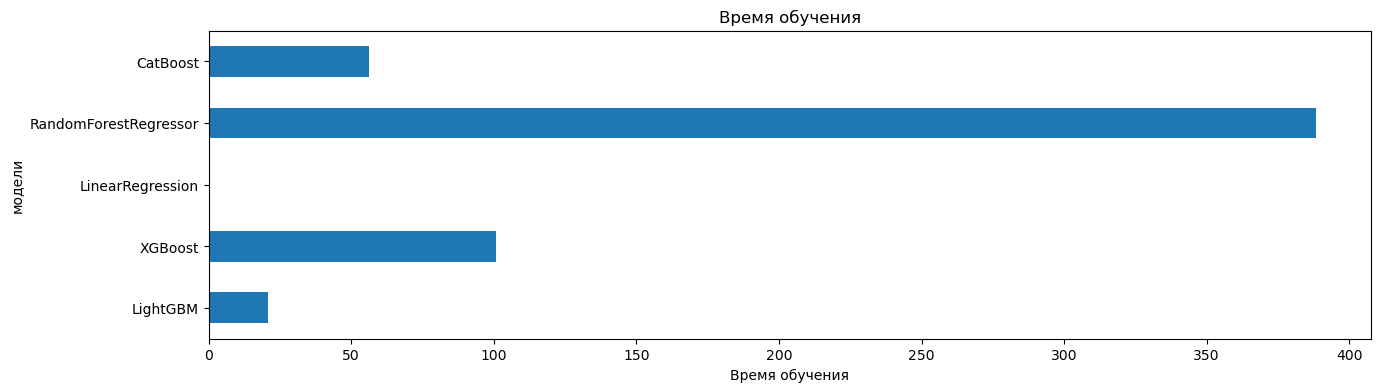

In [152]:
analise_df['time'] = analise_df['time'].dt.total_seconds()
ax = analise_df['time'].plot.barh(figsize=(15,4), legend=False, title='Время обучения')
ax.set_xlabel("Время обучения")
ax.set_ylabel("модели");

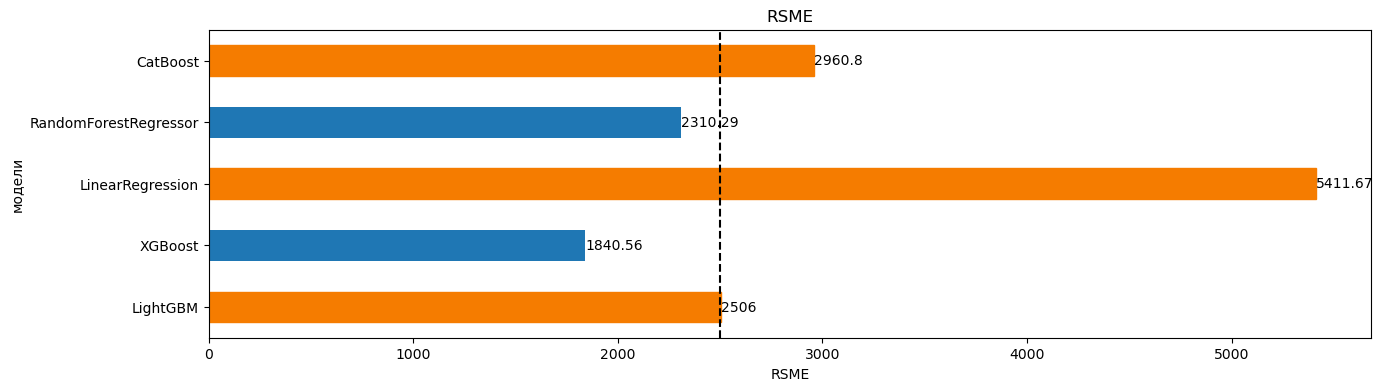

In [153]:
ax = analise_df['RMSE'].plot.barh(figsize=(15,4), legend=False, title='RSME')
ax.axvline(x=2500, color='black', linestyle='--')
ax.bar_label(ax.containers[0], color='black')
for bar in ax.containers[0]:
    if bar.get_width() >= 2500:
        bar.set_color('#F57C00')
ax.set_xlabel("RSME")
ax.set_ylabel("модели");

In [154]:
print(f"Список моделей, удовлетворяющим критерию качества:\n{analise_df[analise_df['RMSE'] < 2500].index.tolist()}")

Список моделей, удовлетворяющим критерию качества:
['XGBoost', 'RandomForestRegressor']


In [155]:
print(f"Модель с лучшим показателем времени обучения (поиска лучших параметров) и качества модели: {analise_df[analise_df['RMSE'] < 2500].sort_values(by=['total_coef']).head(1).index[0]}")

Модель с лучшим показателем времени обучения (поиска лучших параметров) и качества модели: XGBoost


Проверим модель на тестовой выборке

In [156]:
# Создаём модель по полученным параметрам
y_pred = best_model_xgb.predict(encoded_X_test)
rmse_xgb_t = round(mean_squared_error(y_test, y_pred)**(0.5), 2)
print(f"RMSE valid: {rmse_xgb}\nRMSE test: {rmse_xgb_t}")

RMSE valid: 1840.56
RMSE test: 1805.89


Качество модели валидационной и тестовой выборке имеют почти одинаковое значение (разница ~ 2%)

## Общий вывод

**Входные данные**
- В исходных данных было 16 параметров, после удаления неинформативных параметров, осталось 10  
- Целевой признак - "Price"  
- В полученных данных были пропуски и выбросы. В большенстве случаев пропуски заменили на заглушку (. выбросы - совсем большие - удалили (год регистрации, например), часть данные переопределили медианнным значением  


**Модели**  
- Были взяты 5 моделей: LightGBM, XGBoost, LinearRegression, RandomForestRegressor, CatBoost  
- По критерию качества с заранее выбранными параметрами прошли две модели: XGBoost, RandomForestRegressor, CatBoost  
- По времени обучения две модели показали значительно быстрее чем остальные: XGBoost и RandomForestRegressor  


**Лучшая модель**
Т.к. время обучения RandomForestRegressor очень большое, выбрали модель **XGBoost**  
Выбранная модель показала результат качества на одинаковое на валидационной и тестовой выборке